# Explicit Chang Cooper Scheme

---

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from numba import njit, prange
import datetime
import os 

## Model Parameters

In [31]:
sigma = 0.001
beta = 100
lamda = 0.6
alpha = 0.1
v0 = 0.01
vg = 0
psi = np.inf
D0 = 0.00001

## Vectorized Drift and Diffusion Functions
---

### Deterministic Drift: $\dot x$, $\dot z$, $\dot\phi$ and Noise Intensity

The functions below define the deterministic parts of the SDEs
$$
\frac{dx}{dt} = \mu_x(X,Z,\Phi,t), \quad
\frac{dz}{dt} = \mu_z(X,Z,\Phi,t), \quad
\frac{d\phi}{dt} = \mu_\phi(X,Z,\Phi,t),
$$
as well as the (constant) noise intensity.

---

### Deterministic Velocities

- **x–velocity**
  $
  \frac{dx}{dt} = \mu_x
  = \alpha e^{Z}\cos(X - t)\;+\;v_0\sin\Phi\;+\;\sigma(\beta + Z)
  $

- **z–velocity**
  $
  \frac{dz}{dt} = \mu_z
  = \alpha e^{Z}\sin(X - t)\;+\;v_0\cos\Phi\;-\;v_g
  $

- **$\phi$–velocity**
  $
  \frac{d\phi}{dt} = \mu_\phi
  = \lambda\alpha e^{Z}\cos(X - t + 2\Phi)
    \;-\;\frac{1}{2\psi}\sin\Phi
    \;+\;\frac{\sigma}{2}\big(1+\lambda\cos(2\Phi)\big)
  $

Everything has been made dimensionless!

---

### Noise Intensity

The (scalar) noise intensity used for the diffusion term is constant:
$
\mathrm{Var} = D_0.
$

---

### Upper Bounds for CFL Estimates

For CFL checks we use simple upper bounds on the magnitudes of the velocities:
- $
  \mu_{x,\max} = \alpha e^{Z} + v_0 + \sigma(\beta + Z)
  $
- $
  \mu_{z,\max} = \alpha e^{Z} + v_0 - v_g
  $
- $
  \mu_{\phi,\max} = \lambda\alpha e^{Z} - \frac{1}{2\psi} + \frac{\sigma}{2}(1+\lambda)
  $

---
### Modelling Assumptions

In [39]:
def mu_x_vec(X, Z, PHI, t):
    return (alpha*np.exp(Z)*np.cos(X-t)
            + v0*np.sin(PHI)
            + sigma*(beta+Z))

def mu_z_vec(X, Z, PHI, t):
    return alpha*np.exp(Z)*np.sin(X-t) + v0*np.cos(PHI) - vg


def mu_phi_vec(X, Z, PHI, t):
    return (lamda*alpha*np.exp(Z)*np.cos(X-t+2*PHI)
            - 1/(2*psi)*np.sin(PHI)
            + sigma/2*(1+lamda*np.cos(2*PHI)))

def diffusion_vec(X, Z, PHI, t):
    return D0 * np.ones_like(PHI)

def fp_compute_drifts(X, Z, PHI, t):
    """
    Compute drift and diffusion fields on the full 3D grid.

    Evaluates the drift components μ_x, μ_z, μ_φ and the diffusion
    coefficient D at each grid point.

    Parameters
    ----------
    X, Z, PHI : ndarray, shape (Nx, Nz, Nphi)
        Spatial grids in x, z, and φ.
    t : float
        Current time.

    Returns
    -------
    MU_X, MU_Z, MU_PHI, D : ndarray
        Drift components in x, z, φ directions and diffusion field,
        all with shape (Nx, Nz, Nphi).
    """
    MU_X = mu_x_vec(X, Z, PHI, t)
    MU_Z = mu_z_vec(X, Z, PHI, t)
    MU_PHI = mu_phi_vec(X, Z, PHI, t)
    D = diffusion_vec(X, Z, PHI, t)
    return MU_X, MU_Z, MU_PHI, D

# Comuting the maximum velocities for CFL

def mu_x_max(X, Z, PHI, t):
    return alpha*np.exp(Z) + v0 + sigma*(beta+Z)


def mu_z_max(X, Z, PHI, t):
    return alpha*np.exp(Z) + v0 - vg


def mu_phi_max(X, Z, PHI, t):
    return (lamda*alpha*np.exp(Z) - 1/(2*psi) + sigma/2*(1+lamda))

## Explicit Euler Scheme for the 3D Fokker–Planck Equation

We evolve the probability density  
$f = f(x_i, z_j, \phi_k, t)$  
with a fully vectorized explicit Euler step:
$$
f^{n+1} = f^{n} + \Delta t \,\big(\partial_x J_x + \partial_z J_z + \partial_\phi J_\phi\big).
$$

All fluxes are computed at cell faces; advection in $x,z$ uses upwind, the $\phi$-direction uses a Chang–Cooper scheme.

---

### 1. Drift and Diffusion Coefficients

At all grid points $(x_i,z_j,\phi_k)$ and time $t$:

- Drift:
  - $\mu_x = \mu_x(x_i,z_j,\phi_k,t)$  
  - $\mu_z = \mu_z(x_i,z_j,\phi_k,t)$  
  - $\mu_\phi = \mu_\phi(x_i,z_j,\phi_k,t)$
- Diffusion:
  - $\mathrm{Var}(x_i,z_j,\phi_k,t)$  
  - $D = \tfrac12 \,\mathrm{Var}$

These are computed by the vectorized functions `mu_x_vec`, `mu_z_vec`, `mu_phi_vec`, `var_vec`.

---

### 2. X–Direction Flux (Upwind)

We work on a uniform grid with spacing $\Delta x$.

Face drift at $i+\tfrac12$:
$$
\mu_{x,i+\frac12} = \frac12\big(\mu_{x,i} + \mu_{x,i+1}\big).
$$

Upwind flux at $i+\tfrac12$:
$$
F^x_{i+\frac12} =
\begin{cases}
\mu_{x,i+\frac12} \, f_i, & \mu_{x,i+\frac12} \ge 0, \\[4pt]
\mu_{x,i+\frac12} \, f_{i+1}, & \mu_{x,i+\frac12} < 0.
\end{cases}
$$

Similarly for $i-\tfrac12$ using the left face velocity.

Divergence in $x$:
$$
(\partial_x J_x)_i = -\frac{F^x_{i+\frac12} - F^x_{i-\frac12}}{\Delta x}.
$$

Boundary conditions in $x$:
- `open`: only outflow allowed at the boundaries,
- `noflux`: fluxes at outer faces set to zero,
- `periodic`: handled implicitly by `np.roll`.

---

### 3. Z–Direction Flux (Upwind)

Analogous construction in $z$ with spacing $\Delta z$.

Face drift at $j+\tfrac12$:
$$
\mu_{z,j+\frac12} = \frac12\big(\mu_{z,j} + \mu_{z,j+1}\big),
$$

Upwind flux:
$$
F^z_{j+\frac12} =
\begin{cases}
\mu_{z,j+\frac12} \, f_j, & \mu_{z,j+\frac12} \ge 0, \\[4pt]
\mu_{z,j+\frac12} \, f_{j+1}, & \mu_{z,j+\frac12} < 0.
\end{cases}
$$

Divergence in $z$:
$$
(\partial_z J_z)_j = -\frac{F^z_{j+\frac12} - F^z_{j-\frac12}}{\Delta z}.
$$

For `bc_z = 'noflux'`, the fluxes at the lower and upper $z$ boundaries are set to zero.

---

### 4. $\phi$–Direction Flux (Chang–Cooper)

In $\phi$ we use the Chang–Cooper scheme to treat drift–diffusion while preserving positivity and the correct equilibrium.

Face drift and diffusion at $k+\tfrac12$:
$$
\mu_{\phi,k+\frac12} = \frac12\big(\mu_{\phi,k} + \mu_{\phi,k+1}\big), \qquad
D_{k+\frac12} = \frac12\big(D_k + D_{k+1}\big).
$$

Péclet number:
$$
\mathrm{Pe}_{k+\frac12} = \frac{\mu_{\phi,k+\frac12}\,\Delta\phi}{D_{k+\frac12}}.
$$

From $\mathrm{Pe}$ we compute the Chang–Cooper weight
$$
\delta = \delta(\mathrm{Pe}),
$$
implemented by `delta_cc_vec`.

The Chang–Cooper flux at $k+\tfrac12$ is:
$$
J_{\phi,k+\frac12}
= \mu_{\phi,k+\frac12}\big[(1-\delta) f_{k+1} + \delta f_k\big]
  - D_{k+\frac12}\,\frac{f_{k+1} - f_k}{\Delta\phi}.
$$

An analogous expression holds at $k-\tfrac12$. Periodic boundary conditions in $\phi$ are handled by rolling the arrays.

Divergence in $\phi$:
$$
(\partial_\phi J_\phi)_k = -\frac{J_{\phi,k+\frac12} - J_{\phi,k-\frac12}}{\Delta\phi}.
$$

---

### 5. Final Explicit Update and Positivity

The total right-hand side is
$$
\frac{\partial f}{\partial t}
= \partial_x J_x + \partial_z J_z + \partial_\phi J_\phi.
$$

We then perform an explicit Euler step:
$$
f^{n+1} = f^{n} + \Delta t \,\frac{\partial f}{\partial t}.
$$

After the update we enforce non-negativity by clipping small negative values (from roundoff) to zero.


### Numba Math Engine

In [ ]:
# TODO: simplifiy comments and shift them to markdown

BC_OPEN = 0
BC_NOFLUX = 1
BC_PERIODIC = 2

@njit(fastmath=True)
def _delta_cc_scalar(Pe):
    """
    Scalar implementation of the Chang-Cooper weighting.
    delta(Pe) = 1/Pe - 1/(exp(Pe) - 1)
    """
    # 1. Handle small Pe (Taylor expansion limit) to avoid 0/0
    if abs(Pe) < 1e-4:
        return 0.5 - Pe / 12.0
        
    # 2. Handle large positive Pe (avoid overflow in exp)
    # If Pe is huge, exp(Pe) is huge, 1/(exp-1) -> 0.
    # Result -> 1/Pe
    if Pe > 100.0:
        return 1.0 / Pe
        
    # 3. Handle large negative Pe
    # If Pe is negative huge, exp(Pe) -> 0. 
    # 1/(0 - 1) = -1. 
    # Result -> 1/Pe - (-1) = 1 + 1/Pe
    if Pe < -100.0:
        return 1.0 / Pe + 1.0
        
    # 4. Standard Case
    return 1.0 / Pe - 1.0 / (np.exp(Pe) - 1.0)

@njit(parallel=True, fastmath=True)
def fp_step_kernel_numba(f, MU_X, MU_Z, MU_PHI, D, 
                         dx, dz, dphi, dt, 
                         bc_x_int, bc_z_int):
    
    Nx, Nz, Nphi = f.shape
    f_new = np.zeros_like(f)
    
    # Pre-calculate inverse steps for speed
    idx = 1.0 / dx
    idz = 1.0 / dz
    idphi = 1.0 / dphi
    
    # Parallelize over the outer dimension
    for i in prange(Nx):
        for j in range(Nz):
            
            # ---------------------------------------------------------
            # PHASE 1: Pre-calculate PHI Fluxes (Periodic)
            # ---------------------------------------------------------
            # We calculate J at face k+1/2 for the entire ring at once.
            # This avoids re-calculating the expensive delta() twice per face.
            J_phi_faces = np.empty(Nphi, dtype=np.float64)
            
            for k in range(Nphi):
                k_next = 0 if k == Nphi - 1 else k + 1
                
                # Parameters at face k+1/2
                mu_face = 0.5 * (MU_PHI[i, j, k] + MU_PHI[i, j, k_next])
                D_face  = 0.5 * (D[i, j, k]      + D[i, j, k_next])
                
                # Peclet Number
                Pe = mu_face * dphi / (D_face + 1e-16)
                
                # Chang-Cooper Weighting
                delta = _delta_cc_scalar(Pe)
                
                # Flux Formulation:
                # Advection part uses the weighting to interpolate f_face
                # Diffusion part is standard centered difference
                term_adv  = mu_face * ((1.0 - delta) * f[i, j, k] + delta * f[i, j, k_next])
                term_diff = D_face  * (f[i, j, k_next] - f[i, j, k]) * idphi
                
                J_phi_faces[k] = term_adv - term_diff

            # ---------------------------------------------------------
            # PHASE 2: Main Update Loop (X, Z, and applying Phi)
            # ---------------------------------------------------------
            for k in range(Nphi):
                
                # === 1. FLUX IN X (i) ===
                
                # Right Face (i + 1/2)
                if i == Nx - 1:
                    if bc_x_int == BC_OPEN:
                        m = MU_X[i, j, k]
                        F_x_right = m * f[i, j, k] if m > 0 else 0.0
                    else: 
                        F_x_right = 0.0
                else:
                    m = 0.5 * (MU_X[i, j, k] + MU_X[i+1, j, k])
                    val = f[i, j, k] if m >= 0 else f[i+1, j, k]
                    F_x_right = m * val

                # Left Face (i - 1/2)
                if i == 0:
                    if bc_x_int == BC_OPEN:
                        m = MU_X[i, j, k]
                        F_x_left = m * f[i, j, k] if m < 0 else 0.0
                    else: 
                        F_x_left = 0.0
                else:
                    m = 0.5 * (MU_X[i-1, j, k] + MU_X[i, j, k])
                    val = f[i-1, j, k] if m >= 0 else f[i, j, k]
                    F_x_left = m * val
                
                div_x = -(F_x_right - F_x_left) * idx

                # === 2. FLUX IN Z (j) ===
                
                # Top Face (j + 1/2)
                if j == Nz - 1:
                    if bc_z_int == BC_OPEN:
                        m = MU_Z[i, j, k]
                        F_z_top = m * f[i, j, k] if m > 0 else 0.0
                    else: 
                        F_z_top = 0.0
                else:
                    m = 0.5 * (MU_Z[i, j, k] + MU_Z[i, j+1, k])
                    val = f[i, j, k] if m >= 0 else f[i, j+1, k]
                    F_z_top = m * val

                # Bottom Face (j - 1/2)
                if j == 0:
                    if bc_z_int == BC_OPEN:
                        m = MU_Z[i, j, k]
                        F_z_bottom = m * f[i, j, k] if m < 0 else 0.0
                    else: 
                        F_z_bottom = 0.0
                else:
                    m = 0.5 * (MU_Z[i, j-1, k] + MU_Z[i, j, k])
                    val = f[i, j-1, k] if m >= 0 else f[i, j, k]
                    F_z_bottom = m * val
                
                div_z = -(F_z_top - F_z_bottom) * idz

                # === 3. FLUX IN PHI (k) ===
                
                # J_right is J_phi_faces[k]
                # J_left  is J_phi_faces[k-1] (cyclical)
                k_prev = Nphi - 1 if k == 0 else k - 1
                div_phi = -(J_phi_faces[k] - J_phi_faces[k_prev]) * idphi

                # === 4. UPDATE ===
                val_new = f[i, j, k] + dt * (div_x + div_z + div_phi)
                
                # Enforce positivity
                f_new[i, j, k] = max(0.0, val_new)

    return f_new

## Time Evolution Numba

In [ ]:
def solve_fokker_planck_numba(f0, t_array, x_grid, z_grid, phi_grid,
                              bc_x='open', bc_z='open', bc_phi='periodic',
                              verbose=True,save_interval=1, lower_mass_threshold=0.001,
                              time_dependent=True): 
    
    # 1. Map Keywords to Integers
    bc_map = {'open': 0, 'noflux': 1, 'periodic': 2}
    bc_x_int = bc_map[bc_x]
    bc_z_int = bc_map[bc_z]
    
    # 2. Setup Grids
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # Create Meshgrids (Memory intensive, but convenient)
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')
    
    # 3. Memory Allocation
    n_saved_frames = (Nt - 1) // save_interval + 1
    
    # Check estimated memory usage for solution array
    est_mem_mb = (n_saved_frames * Nx * Nz * Nphi * 4) / (1024**2)
    if verbose:
        print(f"Allocating solution array: {est_mem_mb:.1f} MB")
        
    solution = np.zeros((n_saved_frames, Nx, Nz, Nphi), dtype=np.float32)
    t_saved = np.zeros(n_saved_frames)
    
    # Initial Condition
    solution[0] = f0
    t_saved[0] = t_array[0]
    save_idx = 1
    f = f0.copy()
    
    # 4. OPTIMIZATION: Pre-calculate Drifts if static
    if not time_dependent:
        if verbose: print("Time-independent physics detected. Pre-calculating drifts...")
        # Compute once at t=0
        MU_X, MU_Z, MU_PHI, D = fp_compute_drifts(X, Z, PHI, t_array[0])
    else:
        # Define placeholders to avoid UnboundLocalError
        MU_X, MU_Z, MU_PHI, D = None, None, None, None

    
    if verbose:
        print(f"Starting Solver. BCs: X='{bc_x}', Z='{bc_z}'. Steps: {Nt}")
    
    # =========================================================
    # TIME LOOP
    # =========================================================
    for n in range(Nt - 1):
        dt = t_array[n+1] - t_array[n]
        t = t_array[n]
        
        # Option to run a fast time_independent version
        if time_dependent:
            MU_X, MU_Z, MU_PHI, D = fp_compute_drifts(X, Z, PHI, t)
        
        # B. Run Kernel
        f = fp_step_kernel_numba(f, MU_X, MU_Z, MU_PHI, D, 
                                 dx, dz, dphi, dt, 
                                 bc_x_int, bc_z_int)
        
        # C. Save Data
        if (n + 1) % save_interval == 0:
            solution[save_idx] = f
            t_saved[save_idx] = t_array[n+1]
            save_idx += 1
        
        # D. Safety Checks & Monitoring (Every 100 steps)
        if (n+1) % 100 == 0 or n == 0:
            # Quick check for NaNs (Fastest check first)
            if np.isnan(f[0,0,0]) or np.any(np.isnan(f)):
                print(f"NaN detected at step {n+1}!")
                return solution[:save_idx], t_saved[:save_idx]

            # Physics checks
            total_prob = np.sum(f) * dx * dz * dphi
            
            if verbose:
                print(f"Step {n+1}/{Nt-1}, t={t:.4f}, ∫f={total_prob:.6f}")

            # Mass Explosion
            if total_prob > 1.1: 
                print(f"Instability detected (∫f={total_prob:.4f} > 1.1). DT likely too high.")
                return solution[:save_idx], t_saved[:save_idx]
            
            # Mass Depletion (Stop early if empty)
            if total_prob < lower_mass_threshold:
                print(f"⚠️ Simulation Empty (∫f < {lower_mass_threshold}). Stopping early.")
                return solution[:save_idx], t_saved[:save_idx]
    
    return solution, t_saved



## CFL Condition

We have **advection** in the $x$– and $z$–directions and **diffusion** in the $\phi$–direction. The timestep $\Delta t$ must respect all corresponding CFL limits.

---

### Advection in $x$ and $z$

For a pure advection equation
$$
\partial_t f + \mu\,\partial_x f = 0,
$$
the explicit CFL condition is
$$
\mathrm{CFL}_{\mathrm{adv}} = \frac{|\mu|\,\Delta t}{\Delta x} \le 1.
$$

Applied to each direction:

- **$x$–direction**
  $$
  \frac{|\mu_x|_{\max}\,\Delta t}{\Delta x} \le 1
  $$

- **$z$–direction**
  $$
  \frac{|\mu_z|_{\max}\,\Delta t}{\Delta z} \le 1
  $$

This ensures that the drift does not move information more than one grid cell per timestep.

---

### Diffusion in $\phi$

For diffusion,
$$
\partial_t f = D_\phi\,\partial_{\phi\phi} f,
$$
the explicit stability condition is
$$
\mathrm{CFL}_{\mathrm{diff}} = \frac{D_\phi\,\Delta t}{\Delta\phi^{2}} \le \frac12.
$$

This bounds the diffusive update so it does not “jump” over too many grid points in one step.

---

### Combined CFL Requirement

**$$\Delta t \le \min\!\left(\frac{\Delta x}{|\mu_x|_{\max}},\, \frac{\Delta z}{|\mu_z|_{\max}},\, \frac{\Delta\phi^{2}}{2D_{\phi,\max}}\right)$$**



In [ ]:

def max_velocities(x_grid, z_grid, phi_grid, t=0):
    """Compute maximum absolute drift velocities in each direction"""
    x_max = np.abs(mu_x_max(x_grid, z_grid, phi_grid, t)).max()
    z_max = np.abs(mu_z_max(x_grid, z_grid, phi_grid, t)).max()
    phi_max = np.abs(mu_phi_max(x_grid, z_grid, phi_grid, t)).max()

    return x_max, z_max, phi_max

def check_cfl_condition(x_grid, z_grid, phi_grid, dt, t=0, verbose=True):
    """
    Rigorous CFL stability check for 3D Advection-Diffusion.
    """
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # Get Maximum Drifts and Diffusion
    max_mu_x, max_mu_z, max_mu_phi = max_velocities(x_grid, z_grid, phi_grid, t)

    D_phi = D0      
    D_x   = 0.0
    D_z   = 0.0
    
    # Advection Rates (Speed / Distance)
    rate_adv_x   = abs(max_mu_x) / dx
    rate_adv_z   = abs(max_mu_z) / dz
    rate_adv_phi = abs(max_mu_phi) / dphi  

    # Diffusion Rates
    rate_diff_x   = (2 * D_x) / (dx**2)
    rate_diff_z   = (2 * D_z) / (dz**2)
    rate_diff_phi = (2 * D_phi) / (dphi**2)
    
    total_rate = (rate_adv_x + rate_diff_x + 
                  rate_adv_z + rate_diff_z + 
                  rate_adv_phi + rate_diff_phi)
    
    if total_rate == 0:
        dt_max = np.inf
    else:
        dt_max = 1.0 / total_rate

    is_stable = dt <= dt_max
    
    if verbose:
        print("-" * 30)
        print(f"CFL Stability Analysis (dt = {dt:.2e})")
        print("-" * 30)
        print(f"Advection Limits (dt < ...):")
        print(f"  X:   {dx/max_mu_x:.2e} (v={max_mu_x:.2e})")
        print(f"  Z:   {dz/max_mu_z:.2e} (v={max_mu_z:.2e})")
        print(f"  Phi: {dphi/max_mu_phi:.2e} (v={max_mu_phi:.2e})")
        print(f"Diffusion Limits (dt < ...):")
        print(f"  Phi: {dphi**2/(2*D_phi):.2e}")
        print("-" * 30)
        print(f"Combined Max Stable dt: {dt_max:.2e}")
        
        if not is_stable:
            print(f"Unstable: dt is {dt/dt_max:.1f}x larger than limit.")
            print("   Probability will leak due to negative overshoots.")
        else:
            print(f"STABLE")
            
    return dt_max



## Run Program

### Timearray and Grid Setup

In [40]:
# TODO: sort this out

# --- 1. Simulation Constants ---
t_final = 1000
dt = 0.1
Nt = int(t_final / dt) + 1
t_array = np.linspace(0, t_final, Nt)

# --- 2. Grid Setup ---

# X-Direction: 
x_min, x_max = 0, 800
Nx = 250  

# Z-Direction:
z_min, z_max = -7, 0
Nz = 50    

# Phi-Direction: 
phi_min, phi_max = -0.5, 1.5*np.pi
Nphi = 100 

x_grid = np.linspace(x_min, x_max, Nx)
z_grid = np.linspace(z_min, z_max, Nz)
phi_grid = np.linspace(phi_min, phi_max, Nphi)

dx = x_grid[1] - x_grid[0]
dz = z_grid[1] - z_grid[0]
dphi = phi_grid[1] - phi_grid[0]

X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')

# --- 3. Initial Condition (Gaussian) ---
x0, z0, phi0 = 0.0, -2.0, -0.5*np.pi  

# Sigmas: 
sigma_x   = 0.1 # 2.0 * dx    
sigma_z   = 2.0 * dz
sigma_phi = 2.0 * dphi

arg_x   = (X - x0)**2 / (2 * sigma_x**2)
arg_z   = (Z - z0)**2 / (2 * sigma_z**2)
arg_phi = (PHI - phi0)**2 / (2 * sigma_phi**2)

f0 = np.exp(-(arg_x + arg_z + arg_phi))

# Normalize
f0 = f0 / (np.sum(f0) * dx * dz * dphi)

# --- 4. Validation ---
print("="*60)
print("FOKKER-PLANCK SETUP VALIDATION")
print("="*60)
print(f"Grid: {Nx}×{Nz}×{Nphi} ({Nx*Nz*Nphi/1e6:.1f} M cells)")
print(f"Resolutions: dx={dx:.3f} (Req < 0.8), dz={dz:.3f}, dφ={dphi:.3f}")
print(f"Initial Pos: x={x0}, z={z0}, φ={phi0/np.pi:.2f}π")
print(f"Initial Widths: σx={sigma_x:.2f}, σz={sigma_z:.3f}, σφ={sigma_phi:.3f}")
print("-" * 40)
print(f"Estimated CFL Limit (approx): dt < {dx/0.3:.2f}s")
print(f"Current dt: {dt}")

if dx > 1.0:
    print("\n WARNING: dx is too large to resolve cos(x-t). Physics will fail.")
else:
    print("\n Grid resolution looks sufficient for wave physics.")

FOKKER-PLANCK SETUP VALIDATION
Grid: 250×50×100 (1.2 M cells)
Resolutions: dx=3.213 (Req < 0.8), dz=0.143, dφ=0.053
Initial Pos: x=0.0, z=-2.0, φ=-0.50π
Initial Widths: σx=0.10, σz=0.286, σφ=0.105
----------------------------------------
Estimated CFL Limit (approx): dt < 10.71s
Current dt: 0.1



## Initial State - localized Gaussian

In [ ]:
%%capture output_stream
print("="*60)
print("VECTORIZED 3D FOKKER-PLANCK SOLVER")
print("="*60)
print(f"Grid: {Nx}×{Nz}×{Nphi} = {Nx*Nz*Nphi:,} cells")
print(f"Resolution: dx={dx:.3f}, dz={dz:.3f}, dφ={dphi:.3f}")
print(f"x in [{x_min}, {x_max}], z in [{z_min}, {z_max}], φ in [{phi_min}, {phi_max}]")

print(f"Initial ∫f = {np.sum(f0)*dx*dz*dphi:.6f}")
print()

print(f"Time: t ∈ [0, {t_final}], dt={dt:.4e}, Nt={Nt}")

print(f"Total Memory needed: {Nt*Nx*Nz*Nphi*4/1e9:.2f} GB (float32)")
check_cfl_condition(x_grid, z_grid, phi_grid, dt)
print()

# Solve with live plotting
start_time = time.time()

solution = None

# solution = solve_fokker_planck_vectorized(f0, t_array, x_grid, z_grid, phi_grid,
#                                             bc_x='noflux', bc_z='noflux', bc_phi='periodic',
#                                             live_plot=use_live_plot, plot_interval=100, fast = False)


# solution, t_sub = solve_fokker_planck_numba(f0, t_array, x_grid, z_grid, phi_grid,
#                                             bc_x='open', bc_z='open', bc_phi='periodic',
#                                             live_plot=use_live_plot, plot_interval=1000, 
#                                         save_interval=10, lower_mass_threshold=0.01)


elapsed = time.time() - start_time

print()
print("="*60)
print(f"✓ Done! Solution shape: {solution.shape}")
print(f"Final ∫f = {np.sum(solution[-1])*dx*dz*dphi:.6f}")
print(f"Computation time: {elapsed:.2f} seconds")
print(f"   ({elapsed/Nt:.4f} sec/step, {Nx*Nz*Nphi*Nt/elapsed/1e6:.2f} Mcells/sec)")
print("="*60)
print("Done")

AttributeError: 'NoneType' object has no attribute 'shape'

## Saving the np.array

In [38]:
base_name = "data_array"

now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S") 

file_name = f"{base_name}_{timestamp}"
np_file = f"{file_name}" 
txt_file = f"{file_name}.txt"

np.savez_compressed(
    np_file, 
    solution=solution, 
    time=t_sub, 
    x_grid=x_grid, 
    z_grid=z_grid,
    phi_grid=phi_grid 
)

print(f"Successfully saved 4D array to: **{np_file}**")

# Get the captured text
captured_text = output_stream.stdout

try:
    with open(txt_file, 'w') as f:
        f.write(captured_text)
    print(f"Successfully saved output to: **{txt_file}**")
except Exception as e:
    print(f"An error occurred while saving the file: {e}")

NameError: name 't_sub' is not defined

## Plotting the Expected Path

We calculate the marginals and plot the expectation values in every time step.

In [ ]:

def get_expected_path(solution, t_saved, x_grid, z_grid):
    """
    Calculates the center of mass <x>(t) and <z>(t) from the 
    Fokker-Planck probability density evolution.
    
    Parameters
    ----------
    solution : ndarray (Nt, Nx, Nz, Nphi)
        The subsampled output from the FP solver.
    t_saved : ndarray (Nt)
        The time steps corresponding to the solution frames.
    x_grid, z_grid : ndarray
        The 1D spatial grids.
        
    Returns
    -------
    mu_x : ndarray
        Expected x position over time.
    mu_z : ndarray
        Expected z position over time.
    """
    Nt = len(t_saved)
    mu_x = np.zeros(Nt)
    mu_z = np.zeros(Nt)
    
    print(f"Extracting expected paths from {Nt} frames...")
    
    for n in range(Nt):
        f_t = solution[n]
        # 1. Marginalize to get 1D distributions

        p_x = np.sum(f_t, axis=(1, 2)) 
        p_z = np.sum(f_t, axis=(0, 2))
        
        # 2. Calculate Center of Mass (Expectation Value)
        # <x> = Sum(x_i * p_i) / Sum(p_i)
        
        total_prob = np.sum(p_x)
        
        if total_prob > 1e-9:
            mu_x[n] = np.sum(x_grid * p_x) / total_prob
            mu_z[n] = np.sum(z_grid * p_z) / total_prob
        else:
            # Handle empty/finished simulation
            mu_x[n] = mu_x[n-1] if n > 0 else x_grid[0]
            mu_z[n] = mu_z[n-1] if n > 0 else z_grid[0]
            
    return mu_x, mu_z


mean_x, mean_z = get_expected_path(solution, t_sub, x_grid, z_grid)



Extracting expected paths from 551 frames...


Plot saved successfully to: ./Average Plots/average_plot_08.png


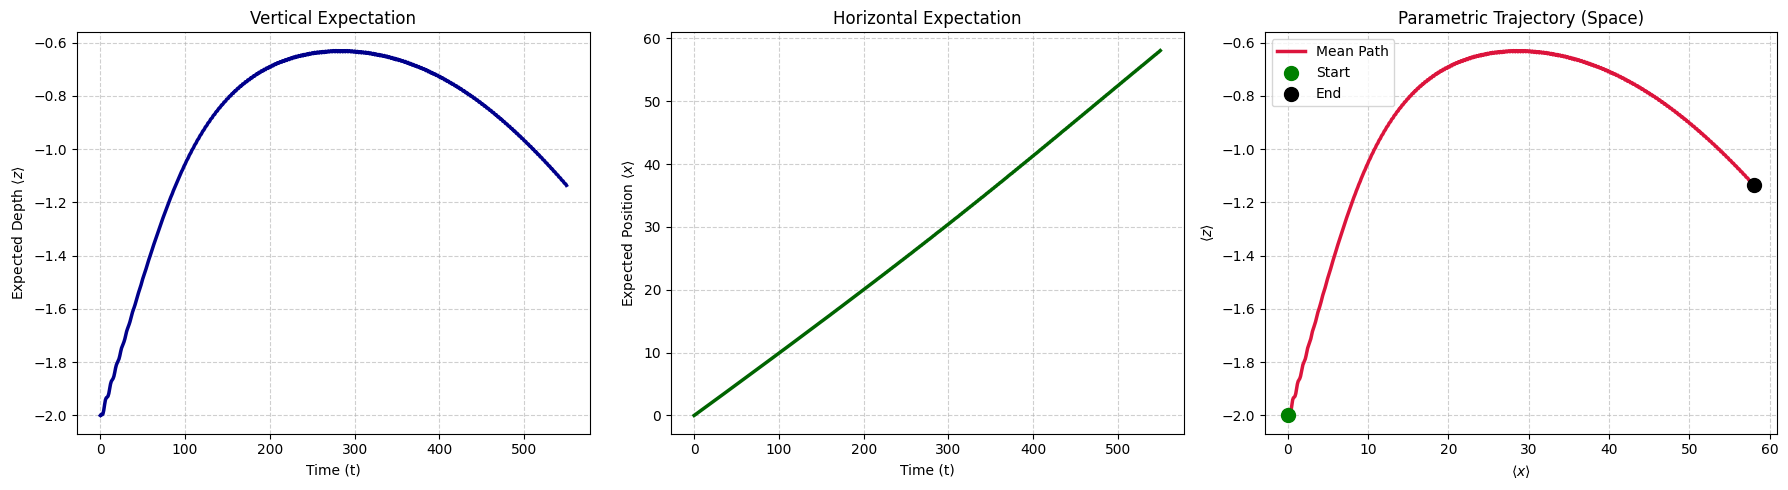

In [ ]:

# 1. Ensure the directory exists
save_dir = "./Average Plots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

# --- Plotting ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Vertical Depth vs Time
ax[0].plot(t_sub, mean_z, color='darkblue', linewidth=2.5)
ax[0].set_xlabel('Time (t)')
ax[0].set_ylabel(r'Expected Depth $\langle z \rangle$')
ax[0].set_title('Vertical Expectation')
ax[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Horizontal Position vs Time
ax[1].plot(t_sub, mean_x, color='darkgreen', linewidth=2.5)
ax[1].set_xlabel('Time (t)')
ax[1].set_ylabel(r'Expected Position $\langle x \rangle$')
ax[1].set_title('Horizontal Expectation')
ax[1].grid(True, linestyle='--', alpha=0.6)

# Plot 3: Parametric Path (Real Space Trajectory)
ax[2].plot(mean_x, mean_z, color='crimson', linewidth=2.5, label='Mean Path')

ax[2].set_xlabel(r'$\langle x \rangle$')
ax[2].set_ylabel(r'$\langle z \rangle$')
ax[2].set_title('Parametric Trajectory (Space)')
ax[2].legend()
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].set_aspect('auto', adjustable='box') 

plt.tight_layout()

save_path = os.path.join(save_dir, "average_plot_08.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Plot saved successfully to: {save_path}")

plt.show()